In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import sys

In [3]:
sys.path.append(os.path.abspath('..'))

# 1. Translate the English training set into Russian

In [2]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
# model_name = "facebook/wmt19-en-ru"
model_name = 'Helsinki-NLP/opus-mt-en-ru'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).cuda();

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

In [5]:
detox_en_train = pd.read_csv('../data/english_data/en_data.csv', sep='\t')

In [6]:
pd.options.display.max_colwidth = 200

In [10]:
detox_en_train.shape

(19766, 9)

In [7]:
detox_en_train.sample(5)

,idx,toxic_comment,neutral_comment,toxicity_score,dataset,toxic,confidence_toxic,is_match,confidence_is_match
17341,150415,"bitch , the japanese invented suicide bombing .",The japanese invented suicide bombing,0.999186,reddit,False,0.9861,True,0.9837
4583,57696,bitch he 19 fuckin feet,He is 19 feet,0.999144,twitter,False,0.9885,True,0.9388
6770,23277,and fucking joel anthony is never open but he 's still dunking on my team,and joel anthony is never open but he 's still dunking on my team,0.991143,twitter,False,0.9941,True,0.9426
16905,197758,shit is about to get real .,Problem is about to get real,0.996396,reddit,False,0.9972,True,0.9625
16808,37406,so what the fuck was the interview ?,So what was the interview?,0.989000,reddit,False,0.9983,True,0.9887


In [8]:
def detokenize(text):
    for symbol in ",.?'":
        text = text.replace(' ' + symbol, symbol)
    return text

In [9]:
from nltk.tokenize import sent_tokenize

In [11]:
def translate(texts, num_beams=5, max_length='auto', **kwargs):
    sentences = []
    sent_sizes = []
    for text in texts:
        sents = sent_tokenize(detokenize(text))
        sentences.extend(sents)
        sent_sizes.append(len(sents))
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    if max_length == 'auto': 
        max_length = int(10 + inputs.input_ids.shape[1] * 1.5)
    with torch.no_grad():
        outputs = model.generate(**inputs.to(model.device), num_beams=num_beams, **kwargs)
    out_sents = [tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
    out_texts = []
    cursor = 0
    for size in sent_sizes:
        out_texts.append(' '.join(out_sents[cursor: cursor+size]))
        cursor += size
    return out_texts

In [12]:
detox_en_train.toxic_comment[:5].tolist()

['he had steel balls too !',
 'dude should have been taken to api , he would be right at home with all the other knuckleheads there',
 'im not gonna sell the fucking picture , i just want to contribute to the fucking article .',
 'the garbage that is being created by cnn and other news agencies is outrageous .',
 'the reason they dont exist is because neither is a pathological liar like trump .']

In [13]:
translate(detox_en_train.toxic_comment[:5].tolist())

['У него тоже были стальные яйца!',
 'Чувак должен был быть в Апи, он был бы прямо дома со всеми другими болванами.',
 'Я не собираюсь продавать эту чертову фотографию, я просто хочу внести свой вклад в эту грёбаную статью.',
 'Отбросы, которые создают КНН и другие агентства новостей, возмутительны.',
 'Причина, по которой их не существует, в том, что и патологический лжец не похож на тромпа.']

In [14]:
translate(detox_en_train.neutral_comment[:5].tolist())

['Он тоже был храбрым!',
 'Было бы неплохо, если бы он пошёл в Апи. Он подойдет.',
 'Я не собираюсь продавать фотографию, я просто хочу внести свой вклад в статью.',
 'Новости, которые создают КНН и другие новостные агентства, возмутительны.',
 'Причина, по которой их не существует, в том, что ни они, ни они не лгут, как лошадь.']

In [15]:
batch_size = 16  # 15 minutes to translate the whole dataset

In [ ]:
toxic_ru = []
neutral_ru = []
for i in trange(0, len(detox_en_train), batch_size):
    toxic_ru.extend(translate(detox_en_train.toxic_comment[i:i+batch_size].tolist()))
    neutral_ru.extend(translate(detox_en_train.neutral_comment[i:i+batch_size].tolist()))

  0%|          | 0/1236 [00:00<?, ?it/s]

In [20]:
detox_en_train['toxic_ru'] = toxic_ru
detox_en_train['neutral_ru'] = neutral_ru

In [19]:
detox_en_train.sample(5)

,idx,toxic_comment,neutral_comment,toxicity_score,dataset,toxic,confidence_toxic,is_match,confidence_is_match,toxic_ru,neutral_ru
6253,61014,i 'll keeepu updated on what time ima be there cus i got school n shit,i 'll keeepu updated on what time ima be there cus i got school n stuff,0.985635,twitter,False,0.9998,True,0.9973,"Я расскажу, в какое время Има будет там, я получу школьное дерьмо.","Я расскажу, в какое время мы будем там, я пойду в школу."
2536,85039,who the fvck wrote this article ?,Who wrote this article ?,0.956034,jigsaw,False,0.9748,True,0.9906,"Кто, чёрт возьми, написал эту статью?",Кто написал эту статью?
17221,98951,i hope they 've sorted their shit out for the next election .,i hope they 've sorted their works out for the next election .,0.983750,reddit,False,0.9904,True,0.9789,"Надеюсь, они разберутся со своим дерьмом на следующих выборах.","Надеюсь, они уладили свои дела на следующих выборах."
10526,11607,you can add 3 & 1 internet to the shit list,You can add 3 &1 internet to the list,0.995667,twitter,False,0.9512,True,0.9749,Вы можете добавить 3 и 1 интернет в список дерьма,Вы можете добавить 3 &lt; 1 Интернет к списку
14304,182334,where the fuck did you get that from ? ?,where did you get that from ? ?,0.997454,reddit,False,0.9987,True,0.9750,"Откуда, блядь, это у тебя? ?",Откуда это у тебя? ?


In [21]:
(detox_en_train.toxic_ru == detox_en_train.neutral_ru).mean()

0.023474653445310127

In [22]:
detox_en_train.toxic_ru.str.len().describe()

count    19766.000000
mean        54.972276
std         23.354563
min         11.000000
25%         37.000000
50%         51.000000
75%         70.000000
max        510.000000
Name: toxic_ru, dtype: float64

In [23]:
detox_en_train.neutral_ru.str.len().describe()

count    19766.000000
mean        47.182687
std         23.409306
min          1.000000
25%         29.000000
50%         43.000000
75%         62.000000
max        510.000000
Name: neutral_ru, dtype: float64

In [24]:
from textdistance import levenshtein

In [25]:
detox_en_train['edit_distance_en'] = [levenshtein.distance(*row) for row in detox_en_train[['toxic_comment', 'neutral_comment']].values]
detox_en_train['edit_distance_ru'] = [levenshtein.distance(*row) for row in detox_en_train[['toxic_ru', 'neutral_ru']].values]

detox_en_train['edit_sim_en'] = [levenshtein.normalized_similarity(*row) for row in detox_en_train[['toxic_comment', 'neutral_comment']].values]
detox_en_train['edit_sim_ru'] = [levenshtein.normalized_similarity(*row) for row in detox_en_train[['toxic_ru', 'neutral_ru']].values]

In [26]:
detox_en_train.describe()

,idx,toxicity_score,confidence_toxic,confidence_is_match,edit_distance_en,edit_distance_ru,edit_sim_en,edit_sim_ru
count,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000,19766.00000,19766.000000,19766.000000
mean,78035.783416,0.990181,0.984174,0.972585,15.705757,21.46327,0.696492,0.602780
std,60839.351686,0.019532,0.025847,0.025094,10.989535,14.26659,0.186762,0.209683
min,7.000000,0.800983,0.523700,0.800000,0.000000,0.00000,0.000000,0.000000
25%,31839.000000,0.991065,0.981100,0.961100,8.000000,11.00000,0.590909,0.451613
50%,63895.000000,0.996133,0.994100,0.980500,12.000000,18.00000,0.741935,0.626667
75%,101255.250000,0.998179,0.998500,0.991100,20.000000,28.00000,0.838710,0.765957
max,238836.000000,0.999647,1.000000,0.999900,105.000000,271.00000,1.000000,1.000000


In [27]:
detox_en_train[['edit_distance_en', 'edit_sim_en']].quantile([0.01, 0.05, 0.90, 0.99])

,edit_distance_en,edit_sim_en
0.01,3.0,0.192308
0.05,5.0,0.312500
0.90,30.0,0.900000
0.99,56.0,0.961538


In [28]:
# detox_en_train[['edit_distance_en', 'edit_sim_en']].quantile([0.01, 0.05, 0.90, 0.99])
print((detox_en_train.edit_distance_ru < 3).mean())
print((detox_en_train.edit_distance_ru > 56).mean())

print((detox_en_train.edit_sim_ru < 0.19).mean())
print((detox_en_train.edit_sim_ru > 0.96).mean())

0.027876150966305777
0.024435900030355156
0.028230294445006576
0.027066680157846808


Score the resulting pairs

In [34]:
from evaluate_ru import evaluate_style_transfer, rotation_calibration, load_model
from transformers import AutoModel

In [35]:
style_model, style_tokenizer = load_model(
    "SkolkovoInstitute/russian_toxicity_classifier", use_cuda=True
)
meaning_model, meaning_tokenizer = load_model(
    "cointegrated/LaBSE-en-ru", use_cuda=True, model_class=AutoModel
)
cola_model, cola_tolenizer = load_model(
    "SkolkovoInstitute/rubert-base-corruption-detector", use_cuda=True
)

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
def evaluate(original, rewritten):
    return evaluate_style_transfer(
        original_texts=original,
        rewritten_texts=rewritten,
        style_model=style_model,
        style_tokenizer=style_tokenizer,
        meaning_model=meaning_model,
        meaning_tokenizer=meaning_tokenizer,
        cola_model=cola_model,
        cola_tokenizer=cola_tolenizer,
        style_target_label=0,
        aggregate=False,
        style_calibration=lambda x: rotation_calibration(x, 0.90),
        meaning_calibration=lambda x: rotation_calibration(x, 1.50),
        fluency_calibration=lambda x: rotation_calibration(x, 1.15, px=0),
    )

In [40]:
eval_result = evaluate(detox_en_train.toxic_ru.tolist(), detox_en_train.neutral_ru.tolist())

Style evaluation


  0%|          | 0/618 [00:00<?, ?it/s]

Meaning evaluation


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

Fluency evaluation


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

Style accuracy:       0.8201743364334106
Meaning preservation: 0.8069980144500732
Joint fluency:        -0.11377539485692978
Joint score:          -0.07197614014148712
Scores after calibration:
Style accuracy:       0.8381569385528564
Meaning preservation: 0.711837887763977
Joint fluency:        0.8691589832305908
Joint score:          0.5257280468940735


In [42]:
detox_en_train.columns

Index(['idx', 'toxic_comment', 'neutral_comment', 'toxicity_score', 'dataset',
       'toxic', 'confidence_toxic', 'is_match', 'confidence_is_match',
       'toxic_ru', 'neutral_ru', 'edit_distance_en', 'edit_distance_ru',
       'edit_sim_en', 'edit_sim_ru'],
      dtype='object')

In [43]:
detox_en2ru = pd.concat([
    detox_en_train, 
    pd.DataFrame(eval_result)
], axis=1)

In [44]:
detox_en2ru.shape

(19766, 19)

In [45]:
detox_en2ru.describe()

,idx,toxicity_score,confidence_toxic,confidence_is_match,edit_distance_en,edit_distance_ru,edit_sim_en,edit_sim_ru,accuracy,similarity,fluency,joint
count,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000,19766.00000,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000
mean,78035.783416,0.990181,0.984174,0.972585,15.705757,21.46327,0.696492,0.602780,0.838157,0.711838,0.869159,0.525728
std,60839.351686,0.019532,0.025847,0.025094,10.989535,14.26659,0.186762,0.209683,0.250159,0.216294,0.172396,0.261383
min,7.000000,0.800983,0.523700,0.800000,0.000000,0.00000,0.000000,0.000000,0.103904,0.000000,0.000000,0.000000
25%,31839.000000,0.991065,0.981100,0.961100,8.000000,11.00000,0.590909,0.451613,0.793939,0.604774,0.788633,0.309918
50%,63895.000000,0.996133,0.994100,0.980500,12.000000,18.00000,0.741935,0.626667,0.974691,0.764827,0.944624,0.554619
75%,101255.250000,0.998179,0.998500,0.991100,20.000000,28.00000,0.838710,0.765957,0.994927,0.873708,1.000000,0.745741
max,238836.000000,0.999647,1.000000,0.999900,105.000000,271.00000,1.000000,1.000000,0.999766,1.000000,1.000000,0.999527


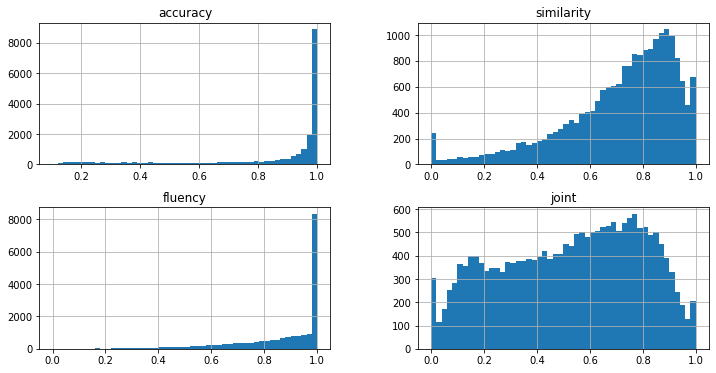

In [55]:
detox_en2ru[['accuracy', 'similarity', 'fluency', 'joint']].hist(bins=50, figsize=(12, 6));

In [56]:
detox_en2ru.to_csv('detox_en2ru.tsv', index=None, sep='\t')

# 2. Train the Russian model 

In [4]:
import pandas as pd

In [5]:
detox_en2ru = pd.read_csv('detox_en2ru.tsv', sep='\t')

In [6]:
from datasets import Dataset, DatasetDict

In [7]:
from sklearn.model_selection import train_test_split

Filter text pairs by similarity to escape translation artifacts

In [8]:
detox_en2ru_filtered = detox_en2ru[
    (detox_en2ru.edit_distance_ru >= detox_en2ru.edit_distance_en.quantile(0.01)) 
    & (detox_en2ru.edit_distance_ru <= detox_en2ru.edit_distance_en.quantile(0.99)) 
    & (detox_en2ru.edit_sim_ru >= detox_en2ru.edit_sim_en.quantile(0.01)) 
    & (detox_en2ru.edit_sim_ru <= detox_en2ru.edit_sim_en.quantile(0.99))
]

print(detox_en2ru.shape)
print(detox_en2ru_filtered.shape)

(19766, 19)
(18239, 19)


In [9]:
train, val = train_test_split(detox_en2ru_filtered, random_state=1, test_size=500)

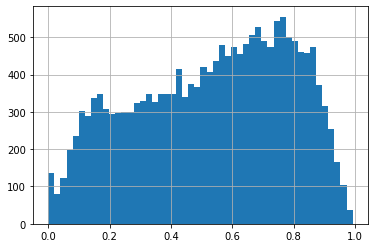

In [10]:
train.joint.hist(bins=50);

In [11]:
train.joint.describe()

count    17739.000000
mean         0.534140
std          0.250634
min          0.000000
25%          0.331690
50%          0.563604
75%          0.745561
max          0.992979
Name: joint, dtype: float64

In [12]:
train_50 = train[train.joint >= train.joint.quantile(0.5)]
train_75 = train[train.joint >= train.joint.quantile(0.25)]

In [13]:
train_75.describe()

,idx,toxicity_score,confidence_toxic,confidence_is_match,edit_distance_en,edit_distance_ru,edit_sim_en,edit_sim_ru,accuracy,similarity,fluency,joint
count,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000,13304.000000
mean,81179.148903,0.989729,0.985415,0.973341,13.799985,19.277661,0.737725,0.648702,0.930931,0.774121,0.904665,0.649284
std,62592.168793,0.019522,0.022921,0.024405,8.486507,10.850949,0.152123,0.167680,0.119426,0.138197,0.125325,0.167927
min,13.000000,0.800983,0.556700,0.800000,1.000000,3.000000,0.125000,0.192308,0.360933,0.338543,0.363357,0.331703
25%,32820.500000,0.990162,0.982900,0.961800,8.000000,11.000000,0.653846,0.534208,0.930174,0.686746,0.843657,0.513213
50%,65873.000000,0.995686,0.994100,0.981100,11.000000,17.000000,0.769231,0.672003,0.985912,0.799477,0.962577,0.658521
75%,110642.000000,0.997891,0.998700,0.991400,17.000000,25.250000,0.852941,0.781818,0.996171,0.883814,1.000000,0.786931
max,238832.000000,0.999645,1.000000,0.999900,73.000000,56.000000,0.982143,0.961039,0.999766,0.999374,1.000000,0.992979


In [14]:
raw_data = DatasetDict({
    'train': Dataset.from_dict({'text': train.toxic_ru, 'target': train.neutral_ru}),
    'train_50': Dataset.from_dict({'text': train_50.toxic_ru, 'target': train_50.neutral_ru}),
    'train_75': Dataset.from_dict({'text': train_75.toxic_ru, 'target': train_75.neutral_ru}),
    'dev': Dataset.from_dict({'text': val.toxic_ru, 'target': val.neutral_ru}),
})
raw_data

DatasetDict({
    train: Dataset({
        features: ['text', 'target'],
        num_rows: 17739
    })
    train_50: Dataset({
        features: ['text', 'target'],
        num_rows: 8870
    })
    train_75: Dataset({
        features: ['text', 'target'],
        num_rows: 13304
    })
    dev: Dataset({
        features: ['text', 'target'],
        num_rows: 500
    })
})

### Compute and evaluate baselines

In [15]:
from sacrebleu import CHRF
chrfpp = CHRF(word_order=2)

Baseline chrf++: 60% if not change the texts. 

In [16]:
chrfpp.corpus_score(val.toxic_ru.tolist(), [val.neutral_ru.tolist()]).score

59.6204444270353

A baseline that removes bad words

In [17]:
from nltk import wordpunct_tokenize
from collections import Counter

def detokenize(text):
    for symbol in ",.?!'":
        text = text.replace(' ' + symbol, symbol)
    return text

class Remover:
    def __init__(self, ratio_threshold=2):
        self.ratio_threshold = ratio_threshold
    def fit(self, x, y):
        self.x_count = Counter(w.lower() for text in x for w in wordpunct_tokenize(text))
        self.y_count = Counter(w.lower() for text in y for w in wordpunct_tokenize(text))
    def predict(self, x):
        results = []
        for text in x:
            words = []
            for w in wordpunct_tokenize(text):
                key = w.lower()
                if (self.x_count[key] + 1) / (self.y_count[key] + 1) > self.ratio_threshold:
                    continue
                words.append(w)
            results.append(detokenize(' '.join(words)))
        return results

In [18]:
remover = Remover(2.0)
remover.fit(train.toxic_ru, train.neutral_ru)

In [19]:
chrfpp.corpus_score(remover.predict(val.toxic_ru), [val.neutral_ru.tolist()]).score

59.37180546341031

A simple word-based translation

In [20]:
from collections import deque
from itertools import product
from tqdm.auto import tqdm

# https://johnlekberg.com/blog/2020-10-25-seq-align.html


def needleman_wunsch(x, y, sim=None, verbose=False):
    """Run the Needleman-Wunsch algorithm on two sequences.

    x, y -- sequences.

    Code based on pseudocode in Section 3 of:

    Naveed, Tahir; Siddiqui, Imitaz Saeed; Ahmed, Shaftab.
    "Parallel Needleman-Wunsch Algorithm for Grid." n.d.
    https://upload.wikimedia.org/wikipedia/en/c/c4/ParallelNeedlemanAlgorithm.pdf
    """
    N, M = len(x), len(y)
    if sim is None:
        s = lambda a, b: int(a == b)
    else:
        s = sim

    DIAG = -1, -1
    LEFT = -1, 0
    UP = 0, -1

    # Create tables F and Ptr
    F = {}
    Ptr = {}

    F[-1, -1] = 0
    for i in range(N):
        F[i, -1] = -i
    for j in range(M):
        F[-1, j] = -j

    option_Ptr = DIAG, LEFT, UP
    for i, j in product(range(N), range(M)):
        option_F = (
            F[i - 1, j - 1] + s(x[i], y[j]),
            F[i - 1, j] - 1,
            F[i, j - 1] - 1,
        )
        F[i, j], Ptr[i, j] = max(zip(option_F, option_Ptr))

    # Work backwards from (N - 1, M - 1) to (0, 0)
    # to find the best alignment.
    alignment = deque()
    i, j = N - 1, M - 1
    if verbose:
        tq = tqdm(total=max(N, M))
        
    while i >= 0 and j >= 0:
        direction = Ptr[i, j]
        if direction == DIAG:
            element = i, j
        elif direction == LEFT:
            element = i, None
        elif direction == UP:
            element = None, j
        alignment.appendleft(element)
        di, dj = direction
        i, j = i + di, j + dj
    while i >= 0:
        alignment.appendleft((i, None))
        i -= 1
    while j >= 0:
        alignment.appendleft((None, j))
        j -= 1

    return list(alignment)

In [21]:
from collections import Counter, defaultdict
import nltk
from tqdm.auto import tqdm, trange
import numpy as np


class TextReplacer:
    def __init__(self, max_n=3, smooth_n=10, min_n=10, min_p=0.01):
        self.max_n = max_n
        self.smooth_n = smooth_n
        self.min_n = min_n
        self.min_p = min_p
        
        self.replace_proba = {}
        self.replaced_tuples = {}
        
    def tokenize(self, text):
        return nltk.wordpunct_tokenize('_bos_ ' + text + ' _eos_')
    
    def detokenize(self, text):
        text = text.strip()
        for symbol in '.,?!':
            text = text.replace(' ' + symbol, symbol)
        if text.startswith('_bos_'):
            text = text[5:]
        if text.endswith('_eos_'):
            text = text[:-5]
        return text.strip()
    
    def fit(self, x_train, y_train):
        raw_counts = Counter()
        replace_counts = Counter()
        
        for i in trange(len(x_train)):
            xx, yy = x_train[i], y_train[i]
            xx, yy = self.tokenize(xx), self.tokenize(yy)
            alignment = needleman_wunsch(xx, yy)
            ixx, iyy = list(zip(*alignment))
            for gram_size in range(1, self.max_n + 1):
                for start in range(len(ixx) - gram_size + 1):
                    xgram = tuple([xx[c] for c in ixx[start: start + gram_size] if c is not None])
                    ygram = tuple([yy[c] for c in iyy[start: start + gram_size] if c is not None])
                    if xgram:
                        xg, yg = ' '.join([''] + list(xgram) + ['']), ' '.join([''] + list(ygram) + [''])
                        raw_counts[xg] += 1
                        if xgram != ygram:
                            replace_counts[(xg, yg)] += 1
    
        self.replace_proba = defaultdict(list)
        self.replaced_tuples = dict()

        for pair, n_sub in replace_counts.most_common():
            if n_sub >= self.min_n:
                xx, yy = pair
                pr = n_sub / (self.smooth_n + raw_counts[xx])
                if pr >= self.min_p:
                    self.replace_proba[xx].append([yy, pr])
                    self.replaced_tuples[tuple(xx.strip().split())] = raw_counts[xx]

        for k, v in self.replace_proba.items():
            tot = sum(p for r, p in v)
            if tot < 1:
                v.append([k, 1 - tot])
        
        return self

    def transform_one(self, text, n_out=None, temperature=None):
        xx = self.tokenize(text)
        found_grams = []
        for gram_size in range(1, self.max_n + 1):
            for start in range(len(xx) - gram_size + 1):
                xgram = tuple([c for c in xx[start: start + gram_size] if c is not None])
                if xgram and xgram in self.replaced_tuples:
                    found_grams.append((xgram, self.replaced_tuples[xgram], len(xgram)))
        found_grams = sorted(found_grams, key=lambda x: (x[2], x[1]), reverse=True)
        
        results = []
        for i in range(n_out or 1):
            untext = ' '.join([''] + xx + [''])
            for gram, gn, gl in found_grams:
                gram_text = ' '.join([''] + list(gram) + [''])
                reps, ww = zip(*self.replace_proba[gram_text])
                if not temperature:
                    chosen_rep = list(reps)[np.argmax(ww)]
                else: # chose randomly
                    weights = [w ** (1 / temperature) for w in ww]
                    chosen_rep = random.choices(list(reps), weights=weights)[0]
                untext = untext.replace(gram_text, chosen_rep)
            results.append(self.detokenize(untext))
        if not n_out:
            return results[0]
        return results
    
    def transform(self, texts, n_out=None, temperature=None):
        return [self.transform_one(text, n_out=n_out, temperature=temperature) for text in tqdm(texts)]

In [22]:
replacer = TextReplacer(min_n=3)
replacer.fit(train.toxic_ru.tolist(), train.neutral_ru.tolist())

  0%|          | 0/17739 [00:00<?, ?it/s]

In [23]:
replacer.transform_one("Какого хуя тут делает этот придурок?")

'Почему тут делает этот?'

In [24]:
chrfpp.corpus_score(replacer.transform(val.toxic_ru), [val.neutral_ru.tolist()]).score

  0%|          | 0/500 [00:00<?, ?it/s]

60.245284369211014

### Prepare test methods

In [25]:
def paraphrase(
    text, model, tokenizer, n=None, max_length="auto", beams=5,
):
    texts = [text] if isinstance(text, str) else text
    inputs = tokenizer(texts, return_tensors="pt", padding=True)["input_ids"].to(
        model.device
    )

    if max_length == "auto":
        max_length = inputs.shape[1] + 10

    result = model.generate(
        inputs,
        num_return_sequences=n or 1,
        do_sample=False,
        temperature=1.0,
        repetition_penalty=10.0,
        max_length=max_length,
        min_length=int(0.5 * max_length),
        num_beams=beams,
        #forced_bos_token_id=tokenizer.lang_code_to_id[tokenizer.tgt_lang],
    )
    texts = [tokenizer.decode(r, skip_special_tokens=True) for r in result]

    if not n and isinstance(text, str):
        return texts[0]
    return texts[0]

In [26]:
test_data = pd.read_csv('../data/russian_data/test.tsv', sep='\t')
test_inputs = test_data["toxic_comment"].values.tolist()

## Fine-tune ruT5-base

In [19]:
# 
# base_model = 'google/mt5-base'
base_model = 'sberbank-ai/ruT5-base'

In [20]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [21]:
model = AutoModelForSeq2SeqLM.from_pretrained(base_model).cuda()
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [22]:
prefix = ""

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, padding=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target"], padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [23]:
tok_data = raw_data.map(preprocess_function, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [24]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [25]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="/home/dale/models/detox-parallel/translate-en2ru-full-rut5",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=1e-5,
    max_steps=10_000,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=1,
    eval_steps=500, 
    save_steps=500,
    logging_steps=500,
    load_best_model_at_end=True,
)

In [26]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tok_data["train"],
    eval_dataset=tok_data["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

max_steps is given, it will override any value given in num_train_epochs


In [27]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: target, text. If target, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/home/dale/p3/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17739
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10000


Step,Training Loss,Validation Loss
500,1.791000,0.529552
1000,0.630500,0.489399
1500,0.574000,0.463955
2000,0.553800,0.459029
2500,0.524600,0.451687
3000,0.511300,0.443014
3500,0.501200,0.440186
4000,0.494100,0.432363
4500,0.487100,0.432016
5000,0.471300,0.429997


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: target, text. If target, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 8
Saving model checkpoint to /home/dale/models/detox-parallel/translate-en2ru-full-rut5/checkpoint-500
Configuration saved in /home/dale/models/detox-parallel/translate-en2ru-full-rut5/checkpoint-500/config.json
Model weights saved in /home/dale/models/detox-parallel/translate-en2ru-full-rut5/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /home/dale/models/detox-parallel/translate-en2ru-full-rut5/checkpoint-500/tokenizer_config.json
Special tokens file saved in /home/dale/models/detox-parallel/translate-en2ru-full-rut5/checkpoint-500/special_tokens_map.json
Copy vocab file to /home/dale/models/detox-parallel/translate-en2ru-full-rut5/checkp

TrainOutput(global_step=10000, training_loss=0.555692317199707, metrics={'train_runtime': 1611.2303, 'train_samples_per_second': 49.652, 'train_steps_per_second': 6.206, 'total_flos': 7229199591060480.0, 'train_loss': 0.555692317199707, 'epoch': 4.51})

In [30]:
from tqdm.auto import tqdm, trange

In [31]:
preds = []
model.eval()
for text in tqdm(val.toxic_ru):
    with torch.inference_mode():
        out = tokenizer.decode(
            model.generate(**tokenizer(text, return_tensors='pt').to(model.device), num_beams=5, max_length=256)[0], 
            skip_special_tokens=True,
        )
        preds.append(out)
        
print(chrfpp.corpus_score(preds, [val.neutral_ru.tolist()]).score)

  0%|          | 0/500 [00:00<?, ?it/s]

61.69545289600716


In [33]:
val.toxic_ru[:5]

4890     Да, я вернулся в этот уединенный зад, мир субт...
2153                           Два дурака не делают права.
18757           Это дерьмо должно прекратиться, сейчас же!
16963    Да, посмотри на всех китайских иммигрантов и и...
17502    Подумай больше, будь скучной маленькой сучкой ...
Name: toxic_ru, dtype: object

In [34]:
preds[:5]

['Да, я вернулся в этот уединенный мир субтитрах и безлежащих лол.',
 'Два человека не делают права.',
 'Это должно прекратиться сейчас же.',
 'Да, посмотри на всех китайских иммигрантов и иммигрантов, которые делают одно и то же.',
 'Подумай больше, будь скучной маленькой девочкой меньше.']

In [ ]:
test_outputs = [paraphrase(text, model, tokenizer) for text in tqdm(test_inputs)]

In [ ]:
with open('../results/translate-train-full/results_ru.txt', 'w') as f:
    for text in test_outputs:
        f.write(text+'\n')

## Fine-tune with filtered data

In [41]:
model = AutoModelForSeq2SeqLM.from_pretrained(base_model).cuda()
tokenizer = AutoTokenizer.from_pretrained(base_model)

loading configuration file https://huggingface.co/sberbank-ai/ruT5-base/resolve/main/config.json from cache at /home/dale/.cache/huggingface/transformers/15f5f9138b337892ef8dadfab622952847d6eb4b5985a825847fbaa18538bae9.d9b947fcfcea30df5eb71effa3afe0a2e3da3535463b97a14c3c0401ac680b99
Model config T5Config {
  "_name_or_path": "sberbank-ai/ruT5-base",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "

In [42]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="/home/dale/models/detox-parallel/translate-en2ru-filter75best-rut5",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=1e-5,
    max_steps=10_000,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=1,
    eval_steps=500, 
    save_steps=500,
    logging_steps=500,
    load_best_model_at_end=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [43]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tok_data["train_75"],
    eval_dataset=tok_data["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

max_steps is given, it will override any value given in num_train_epochs


In [44]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: target, text. If target, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/home/dale/p3/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13304
  Num Epochs = 7
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10000


Step,Training Loss,Validation Loss
500,1.749800,0.529447
1000,0.623400,0.487823
1500,0.561700,0.474613
2000,0.541200,0.460573
2500,0.506300,0.454732
3000,0.505900,0.448597
3500,0.480400,0.446434
4000,0.469600,0.441509
4500,0.474900,0.440623
5000,0.466500,0.435725


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: target, text. If target, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 8
Saving model checkpoint to /home/dale/models/detox-parallel/translate-en2ru-filter75best-rut5/checkpoint-500
Configuration saved in /home/dale/models/detox-parallel/translate-en2ru-filter75best-rut5/checkpoint-500/config.json
Model weights saved in /home/dale/models/detox-parallel/translate-en2ru-filter75best-rut5/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /home/dale/models/detox-parallel/translate-en2ru-filter75best-rut5/checkpoint-500/tokenizer_config.json
Special tokens file saved in /home/dale/models/detox-parallel/translate-en2ru-filter75best-rut5/checkpoint-500/special_tokens_map.json
Copy vocab file to /home/dale/models/detox-p

TrainOutput(global_step=10000, training_loss=0.537236734008789, metrics={'train_runtime': 1369.1657, 'train_samples_per_second': 58.43, 'train_steps_per_second': 7.304, 'total_flos': 5148767509585920.0, 'train_loss': 0.537236734008789, 'epoch': 6.01})

In [48]:
test_outputs = [paraphrase(text, model, tokenizer) for text in tqdm(test_inputs)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
# with open('../results/translate-train-full/results_ru.txt', 'w') as f:
with open('../results/translate-train-filter75best/results_ru.txt', 'w') as f:
    for text in test_outputs:
        f.write(text+'\n')

## Fine-tune mBART

In [27]:
base_model = 'facebook/mbart-large-50'

In [28]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [29]:
model = AutoModelForSeq2SeqLM.from_pretrained(base_model)# .cuda()
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [30]:
prefix = ""

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, padding=True)
    labels = tokenizer(examples["target"], padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [31]:
tok_data = raw_data.map(preprocess_function, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [48]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="/home/dale/models/detox-parallel/translate-en2ru-full-mbart",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=1, # 8 is too much 
    weight_decay=1e-5,
    max_steps=10_000,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=1,
    eval_steps=500, 
    save_steps=500,
    logging_steps=500,
    load_best_model_at_end=True,
    # trying to save memory: see https://huggingface.co/docs/transformers/performance
    fp16=True,
    gradient_checkpointing=True,
    optim="adafactor",
    gradient_accumulation_steps=1,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [49]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tok_data["train"],
    eval_dataset=tok_data["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

max_steps is given, it will override any value given in num_train_epochs
Using amp half precision backend


In [50]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: text, target. If text, target are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 17739
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10000


Step,Training Loss,Validation Loss
500,0.464100,0.427477
1000,0.454000,0.404340
1500,0.435100,0.388027
2000,0.423300,0.380501
2500,0.370500,0.378985
3000,0.339700,0.374920
3500,0.332700,0.369522
4000,0.333100,0.361089
4500,0.324200,0.369869
5000,0.269400,0.377038


/home/dale/p3/lib/python3.7/site-packages/transformers/trainer.py:1599: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,
The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: text, target. If text, target are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1
Saving model checkpoint to /home/dale/models/detox-parallel/translate-en2ru-full-mbart/checkpoint-500
Configuration saved in /home/dale/models/detox-parallel/translate-en2ru-full-mbart/checkpoint-500/config.json
Model weights saved in /home/dale/models/d

TrainOutput(global_step=10000, training_loss=0.3072514045715332, metrics={'train_runtime': 3919.3933, 'train_samples_per_second': 20.411, 'train_steps_per_second': 2.551, 'total_flos': 1.0544019625918464e+16, 'train_loss': 0.3072514045715332, 'epoch': 4.51})

In [51]:
from tqdm.auto import tqdm, trange

In [52]:
preds = []
model.eval()
for text in tqdm(val.toxic_ru):
    with torch.inference_mode():
        out = tokenizer.decode(
            model.generate(**tokenizer(text, return_tensors='pt').to(model.device), num_beams=5, max_length=256)[0], 
            skip_special_tokens=True,
        )
        preds.append(out)
        
print(chrfpp.corpus_score(preds, [val.neutral_ru.tolist()]).score)

  0%|          | 0/500 [00:00<?, ?it/s]

61.30470213875236


In [53]:
val.toxic_ru[:5]

4890     Да, я вернулся в этот уединенный зад, мир субт...
2153                           Два дурака не делают права.
18757           Это дерьмо должно прекратиться, сейчас же!
16963    Да, посмотри на всех китайских иммигрантов и и...
17502    Подумай больше, будь скучной маленькой сучкой ...
Name: toxic_ru, dtype: object

In [54]:
preds[:5]

['Да, я вернулся в этот уединенный мир субтитров и безлежащих лол',
 'Два человека не делают права.',
 'Это должно прекратиться, сейчас же!',
 'Да, посмотри на всех китайских иммигрантов и иммигрантов-задниц, которые делают одно и то же',
 'Подумай больше, будь скучной.']

In [55]:
test_outputs = [paraphrase(text, model, tokenizer) for text in tqdm(test_inputs)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [56]:
with open('../results/translate-train-full-mbart/results_ru.txt', 'w') as f:
    for text in test_outputs:
        f.write(text+'\n')

### Fine-tune mBART with BOTH English (original) and Russian (translated) data

In [27]:
raw_data = DatasetDict({
    'train': Dataset.from_dict({
        'text': train.toxic_ru.tolist() + train.toxic_comment.tolist(), 
        'target': train.neutral_ru.tolist() + train.neutral_comment.tolist()}),
    'dev': Dataset.from_dict({'text': val.toxic_ru, 'target': val.neutral_ru}),
})
raw_data

DatasetDict({
    train: Dataset({
        features: ['text', 'target'],
        num_rows: 35478
    })
    dev: Dataset({
        features: ['text', 'target'],
        num_rows: 500
    })
})

In [28]:
base_model = 'facebook/mbart-large-50'

In [29]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [30]:
model = AutoModelForSeq2SeqLM.from_pretrained(base_model)# .cuda()
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [31]:
prefix = ""

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, padding=True)
    labels = tokenizer(examples["target"], padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [32]:
tok_data = raw_data.map(preprocess_function, batched=True)

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [34]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="/home/dale/models/detox-parallel/translate-en2ru-full_bilingual-mbart",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=1, # 8 is too much 
    weight_decay=1e-5,
    max_steps=10_000,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=1,
    eval_steps=500, 
    save_steps=500,
    logging_steps=500,
    load_best_model_at_end=True,
    # trying to save memory: see https://huggingface.co/docs/transformers/performance
    fp16=True,
    gradient_checkpointing=True,
    optim="adafactor",
    gradient_accumulation_steps=1,
)

In [35]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tok_data["train"],
    eval_dataset=tok_data["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

max_steps is given, it will override any value given in num_train_epochs
Using amp half precision backend


In [ ]:
1

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: target, text. If target, text are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 35478
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10000
/home/dale/p3/lib/python3.7/site-packages/transformers/trainer.py:1599: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,


Step,Training Loss,Validation Loss
500,2.753400,0.483804
1000,0.488500,0.427407
1500,0.430500,0.413124
2000,0.426700,0.400756
2500,0.419600,0.400767
3000,0.410500,0.387422
3500,0.402500,0.379763
4000,0.389400,0.376156
4500,0.378300,0.374747
5000,0.325200,0.372850


The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: target, text. If target, text are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1
Saving model checkpoint to /home/dale/models/detox-parallel/translate-en2ru-full_bilingual-mbart/checkpoint-500
Configuration saved in /home/dale/models/detox-parallel/translate-en2ru-full_bilingual-mbart/checkpoint-500/config.json
Model weights saved in /home/dale/models/detox-parallel/translate-en2ru-full_bilingual-mbart/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /home/dale/models/detox-parallel/translate-en2ru-full_bilingual-mbart/checkpoint-500/tokenizer_config.json
Special tokens file saved in /home/dale/models/detox-parallel/translate-en2ru-full_bilingual-mbart/checkpoint-500/special_tokens_map.json
The following columns i

In [ ]:
from tqdm.auto import tqdm, trange

In [ ]:
preds = []
model.eval()
for text in tqdm(val.toxic_ru):
    with torch.inference_mode():
        out = tokenizer.decode(
            model.generate(**tokenizer(text, return_tensors='pt').to(model.device), num_beams=5, max_length=256)[0], 
            skip_special_tokens=True,
        )
        preds.append(out)

In [42]:
print(chrfpp.corpus_score(preds, [val.neutral_ru.tolist()]).score)

61.41759247020497


In [43]:
val.toxic_ru[:5]

4890     Да, я вернулся в этот уединенный зад, мир субт...
2153                           Два дурака не делают права.
18757           Это дерьмо должно прекратиться, сейчас же!
16963    Да, посмотри на всех китайских иммигрантов и и...
17502    Подумай больше, будь скучной маленькой сучкой ...
Name: toxic_ru, dtype: object

In [44]:
preds[:5]

['Да, я вернулся в этот уединенный мир субтитра и безлежащих лол',
 'Два человека не делают права.',
 'Это должно прекратиться, сейчас же!',
 'Да, посмотри на всех китайских иммигрантов и иммигрантов, которые делают одно и то же.',
 'Подумай больше, будь скучной.']

In [46]:
test_outputs = [paraphrase(text, model, tokenizer) for text in tqdm(test_inputs)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
with open('../results/translate-train-full_bilingual-mbart/results_ru.txt', 'w') as f:
    for text in test_outputs:
        f.write(text+'\n')

# 3. Evaluation results

Dropping the 25% worst text pairs results in a slight increase in meaning and style scores. 

However, we do not know whether it really translates into better quality, or it is just overfitting to the metrics. 

```
python evaluate_ru.py \
    --result_filename scores \
    --input_dir results/translate-train-full \
    --output_dir results
```

```
Style accuracy:       0.4402829706668854
Meaning preservation: 0.8662738800048828
Joint fluency:        -0.1310407668352127
Joint score:          -0.04819316789507866
Scores after calibration:
Style accuracy:       0.49625468254089355
Meaning preservation: 0.7994107604026794
Joint fluency:        0.849303126335144
Joint score:          0.3282524347305298
```

```
python evaluate_ru.py \
    --result_filename scores \
    --input_dir results/translate-train-filter75best \
    --output_dir results
```

```
Style accuracy:       0.46567192673683167
Meaning preservation: 0.8696921467781067
Joint fluency:        -0.1312914490699768
Joint score:          -0.05280234292149544
Scores after calibration:
Style accuracy:       0.5191047191619873
Meaning preservation: 0.8045381903648376
Joint fluency:        0.8490148782730103
Joint score:          0.3441106677055359
```

mBART is more fluent than RuT5!

```
python evaluate_ru.py \
    --result_filename scores \
    --input_dir results/translate-train-full-mbart \
    --output_dir results
    
Style accuracy:       0.4556241035461426
Meaning preservation: 0.8801424503326416
Joint fluency:        -0.10965493321418762
Joint score:          -0.04347466304898262
Scores after calibration:
Style accuracy:       0.5100616812705994
Meaning preservation: 0.8203034400939941
Joint fluency:        0.8738968372344971
Joint score:          0.35575705766677856
```

```
python evaluate_ru.py \
    --result_filename scores \
    --input_dir results/translate-train-full_bilingual-mbart \
    --output_dir results
    
Style accuracy:       0.5142309665679932
Meaning preservation: 0.8898885250091553
Joint fluency:        -0.08569465577602386
Joint score:          -0.04080545902252197
Scores after calibration:
Style accuracy:       0.5628078579902649
Meaning preservation: 0.8349745273590088
Joint fluency:        0.9014511704444885
Joint score:          0.41200950741767883
```